In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import time
from itertools import combinations, chain

from scipy.sparse import csr_matrix
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances


In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_adata/merged.anndata.h5ad"

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
adata.X = csr_matrix(adata.X) 
sc.logging.print_memory_usage()
adata

Memory usage: current 4.11 GB, difference +4.11 GB
Memory usage: current 4.11 GB, difference +0.00 GB


AnnData object with n_obs × n_vars = 166703 × 19311
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat'
    var: 'gene_name', 'ensemble_id'

In [3]:
adata.obs['cell_type'].value_counts()

cell_type
FB                        26586
CD4                       11925
HSC                       11863
EryP                      10788
MPP                        9553
Refined.HSC                9194
iHSC                       8574
CD8                        8376
MEP                        7593
Mono                       7251
ProB                       6862
LinNegCD34PosCD164Pos      6343
GMP                        4984
LinNegCD34NegCD164high     4434
MDP                        4273
LinNegCD34lowCD164high     4266
NK                         4246
MKP                        4058
CLP                        3702
B                          3466
CMP                        2931
pDC                        1882
cDC                         936
LMPP                        817
Plasma                      727
PreBNK                      592
LinNegCD34NegCD164low       358
MLP                         123
Name: count, dtype: int64

In [4]:
# break

# Gene set selection

In [5]:
gene_mask, counts = sc.pp.filter_genes(
    adata, 
    min_cells=100, 
    inplace=False,
)
selected_genes = adata.var[gene_mask]
print(f"{selected_genes.shape=}")
selected_genes.head()

selected_genes.shape=(3783, 2)


,gene_name,ensemble_id
gene_name,,
AAK1,AAK1,ENSG00000115977
AAMDC,AAMDC,ENSG00000087884
AATF,AATF,ENSG00000275700
ABCA1,ABCA1,ENSG00000165029
ABCB7,ABCB7,ENSG00000131269


odict_keys([])

# Preprocessing

In [6]:
def process_anndata(adata, gene_list=None):
    """
    Processes an AnnData object by normalizing and converting its data to a sparse DataFrame.

    Args:
        adata: The AnnData object to process.

    Returns:
        A sparse DataFrame containing the processed data.
    """
    if not gene_list is None:
        adata = adata[:, gene_list].copy()
    else:
        adata = adata.copy()

    # Normalize the AnnData object (creates a copy internally)
    sc.pp.normalize_total(adata, target_sum=1)

    # Convert the data to a sparse CSR matrix
    sparse_matrix = csr_matrix(adata.X)

    # Create a sparse DataFrame from the sparse matrix
    sparse_df = pd.DataFrame.sparse.from_spmatrix(
        sparse_matrix,
        index=adata.obs_names,
        columns=adata.var_names
    )

    return sparse_df


gene_list = selected_genes['gene_name'].to_list()
total_mem = 0
matrix = {} # for the results
for cell_type, group in adata.obs.groupby('cell_type', observed=True):
    
    group_idx = group.index
    X = process_anndata(adata[group_idx, :], gene_list=gene_list)
    
    memory_usage = X.memory_usage(deep=True).sum() / 1024**3
    total_mem += memory_usage
    
    print(f"{cell_type=} {X.shape=} ({memory_usage:.2f} Gb)")
    matrix[cell_type] = X
    
print('done.')
print(f'Total Mem: {total_mem:.2f} Gb')

cell_type='B' X.shape=(3466, 3783) (0.04 Gb)
cell_type='CD4' X.shape=(11925, 3783) (0.12 Gb)
cell_type='CD8' X.shape=(8376, 3783) (0.08 Gb)
cell_type='CLP' X.shape=(3702, 3783) (0.06 Gb)
cell_type='CMP' X.shape=(2931, 3783) (0.04 Gb)
cell_type='EryP' X.shape=(10788, 3783) (0.18 Gb)
cell_type='FB' X.shape=(26586, 3783) (0.51 Gb)
cell_type='GMP' X.shape=(4984, 3783) (0.08 Gb)
cell_type='HSC' X.shape=(11863, 3783) (0.17 Gb)
cell_type='LMPP' X.shape=(817, 3783) (0.01 Gb)
cell_type='LinNegCD34NegCD164high' X.shape=(4434, 3783) (0.03 Gb)
cell_type='LinNegCD34NegCD164low' X.shape=(358, 3783) (0.00 Gb)
cell_type='LinNegCD34PosCD164Pos' X.shape=(6343, 3783) (0.05 Gb)
cell_type='LinNegCD34lowCD164high' X.shape=(4266, 3783) (0.05 Gb)
cell_type='MDP' X.shape=(4273, 3783) (0.07 Gb)
cell_type='MEP' X.shape=(7593, 3783) (0.14 Gb)
cell_type='MKP' X.shape=(4058, 3783) (0.08 Gb)
cell_type='MLP' X.shape=(123, 3783) (0.00 Gb)
cell_type='MPP' X.shape=(9553, 3783) (0.15 Gb)
cell_type='Mono' X.shape=(7251, 3

# Distances

In [7]:
metric = 'cosine'
# metric = 'euclidean'
results = []

start_time = time.time()  # Start timing the entire process

def get_pairs(items):
    pairs = combinations(items, 2)
    self_loops = [(x, x) for x in items]
    return list(chain(pairs, self_loops))

cell_types = [
    'iHSC',
    'HSC',
    'MEP',
    'MKP',
    'MPP',
    'MLP',
    'Refined.HSC',
]

key_pairs = get_pairs(cell_types)
print(f"Considered comparisons: {len(key_pairs)}")


distances = {}

for i, j in key_pairs:
    Xi = matrix[i]
    Xj = matrix[j]
    
    iter_start_time = time.time()  # Start timing this iteration

    D = pairwise_distances(Xi, Xj, metric=metric)
    # D = pd.DataFrame(D, index=Xi.index, columns=Xj.index)

    iter_end_time = time.time()  # End timing this iteration
    print(f"Iteration ({i}, {j}) took {iter_end_time - iter_start_time:.2f} seconds")

    row = {
        'cell_i': i,
        'cell_j': j,
        'N_i': Xi.shape[0],
        'N_j': Xj.shape[0],
        'mean_distance': np.mean(D),
        'std_distance': np.std(D),
        'median_distance': np.median(D),
        'min_distance': np.min(D),
        'max_distance': np.max(D),
        'seconds' : iter_end_time - iter_start_time,
    }
    results.append(row)
    # break  # Remove this break if you want to process all pairs

results = pd.DataFrame(results)

end_time = time.time()  # End timing the entire process
print(f"Total processing time: {end_time - start_time:.2f} seconds")

results.head()

Considered comparisons: 28
Iteration (iHSC, HSC) took 11.95 seconds
Iteration (iHSC, MEP) took 7.91 seconds
Iteration (iHSC, MKP) took 4.57 seconds
Iteration (iHSC, MPP) took 9.72 seconds
Iteration (iHSC, MLP) took 0.86 seconds
Iteration (iHSC, Refined.HSC) took 9.31 seconds
Iteration (HSC, MEP) took 10.68 seconds
Iteration (HSC, MKP) took 6.36 seconds
Iteration (HSC, MPP) took 13.14 seconds
Iteration (HSC, MLP) took 1.26 seconds
Iteration (HSC, Refined.HSC) took 12.74 seconds
Iteration (MEP, MKP) took 4.20 seconds
Iteration (MEP, MPP) took 8.75 seconds
Iteration (MEP, MLP) took 0.86 seconds
Iteration (MEP, Refined.HSC) took 8.64 seconds
Iteration (MKP, MPP) took 5.07 seconds
Iteration (MKP, MLP) took 0.48 seconds
Iteration (MKP, Refined.HSC) took 4.82 seconds
Iteration (MPP, MLP) took 1.00 seconds
Iteration (MPP, Refined.HSC) took 10.41 seconds
Iteration (MLP, Refined.HSC) took 0.86 seconds
Iteration (iHSC, iHSC) took 8.70 seconds
Iteration (HSC, HSC) took 16.80 seconds
Iteration (MEP

,cell_i,cell_j,N_i,N_j,mean_distance,std_distance,median_distance,min_distance,max_distance,seconds
0,iHSC,HSC,8574,11863,0.965894,0.013335,0.966573,0.782650,1.0,11.952402
1,iHSC,MEP,8574,7593,0.966969,0.012591,0.967129,0.848812,1.0,7.906178
2,iHSC,MKP,8574,4058,0.962613,0.011092,0.963423,0.833591,1.0,4.573164
3,iHSC,MPP,8574,9553,0.965430,0.011281,0.966370,0.854545,1.0,9.722860
4,iHSC,MLP,8574,123,0.982362,0.006438,0.983210,0.928775,1.0,0.863060


In [8]:
# break

# visualization

A.shape=(7, 7)


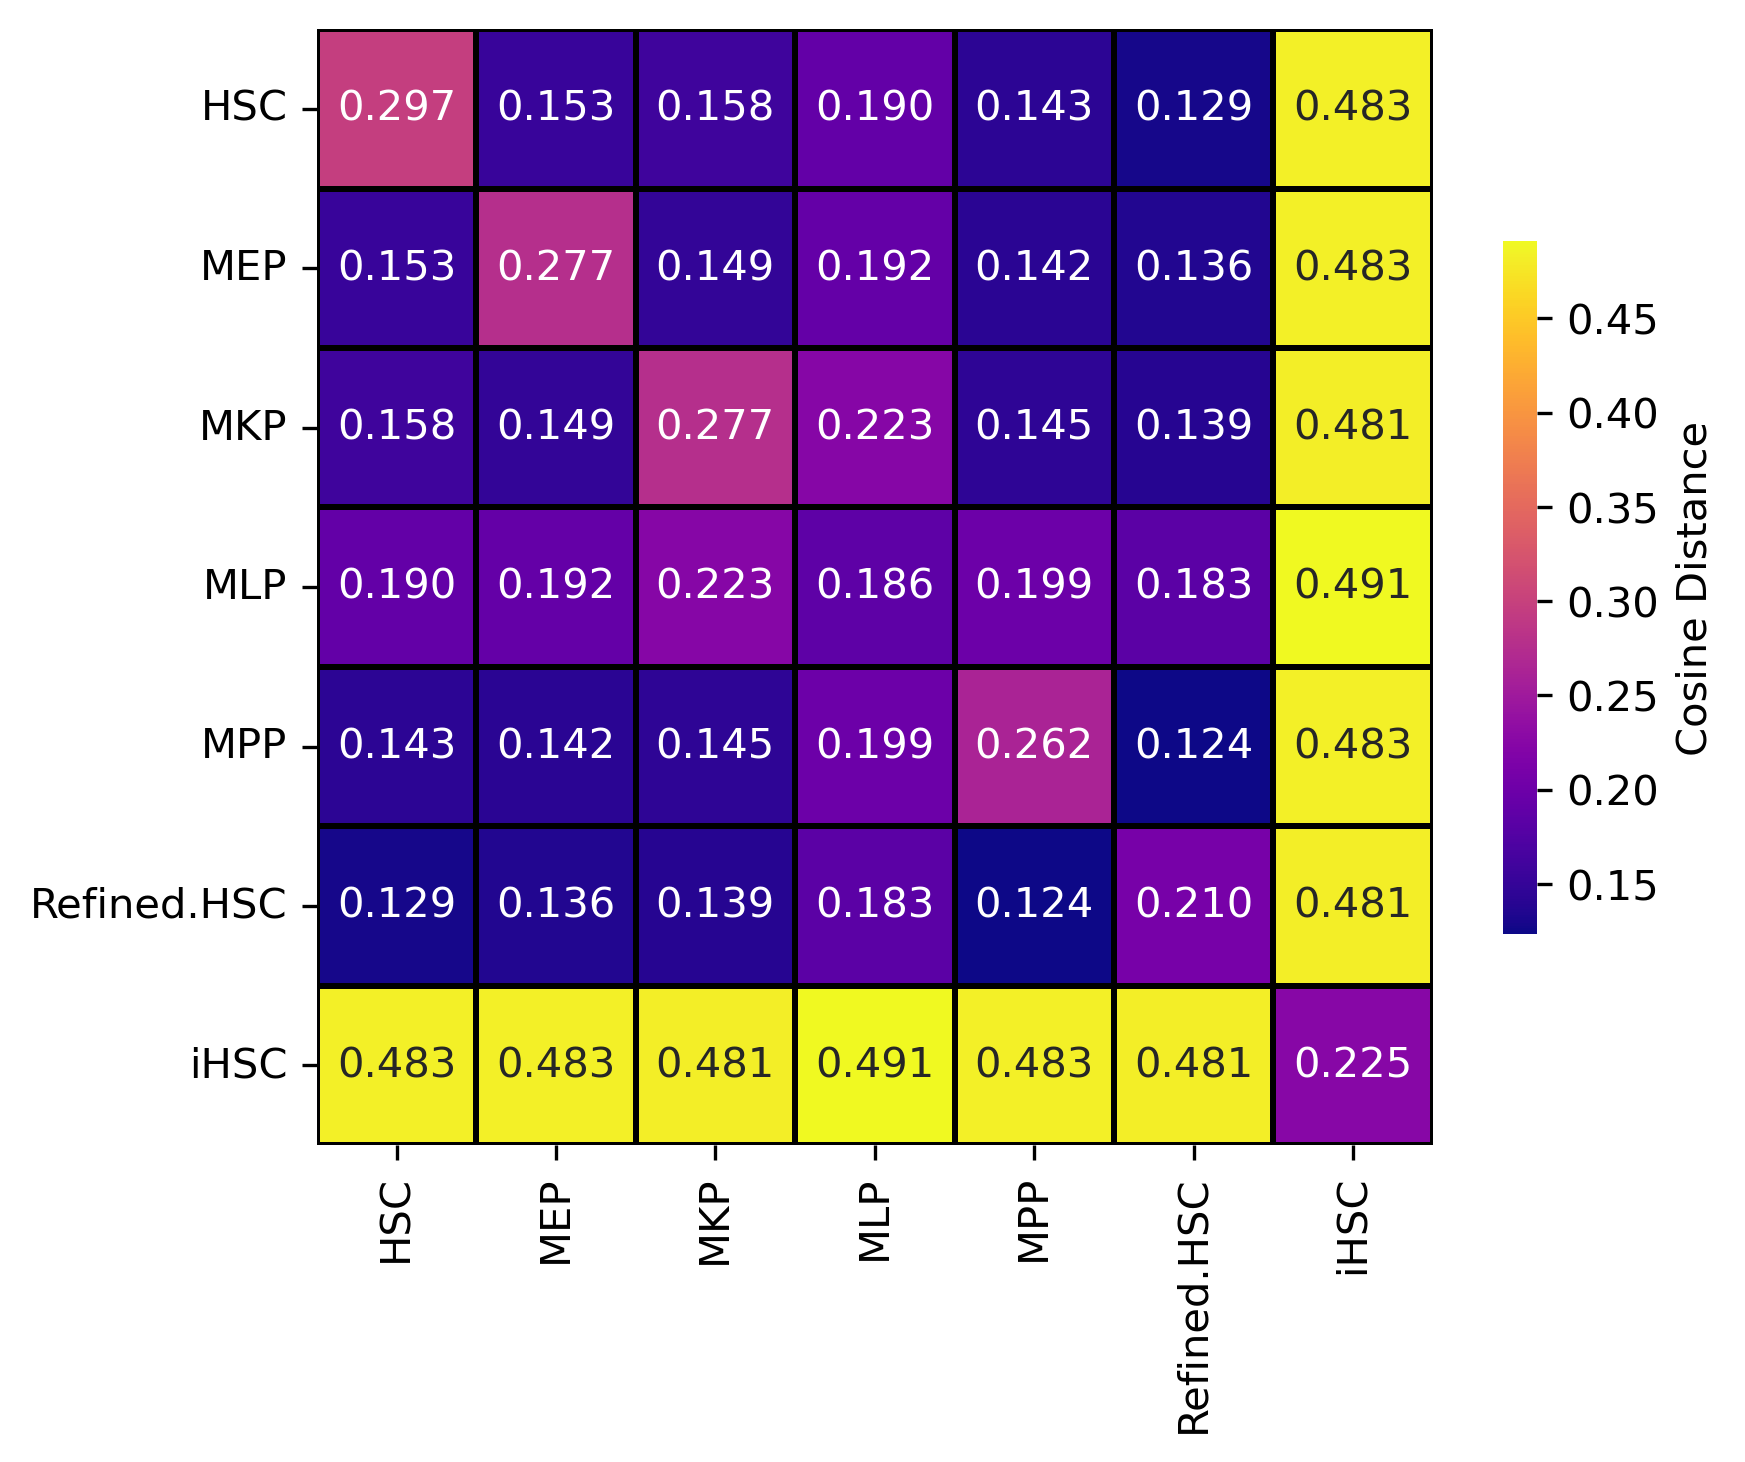

In [9]:
A = pd.pivot_table(
    results, 
    index='cell_i',
    columns='cell_j',
    values='mean_distance',
    fill_value=0,
)

A = (A.T + A) / 2

print(f"{A.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

ax = sns.heatmap(
    A,
    square=True,
    linecolor='k',
    lw=1,
    fmt=".3f",
    annot=True,
    cmap='plasma',
    cbar_kws={'shrink': 0.5, 'label' : f'{metric.title()} Distance'}
)

plt.ylabel("")
plt.xlabel("")

ax.tick_params(axis='y', rotation=0)
    
plt.show()

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
break